# Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Database connection (for later MySQL work)
from sqlalchemy import create_engine
import pymysql

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set plotly default theme
pio.templates.default = "plotly_white"

print("Libraries imported successfully!")

Libraries imported successfully!


# Load All Datasets

In [3]:
# Load all datasets
country_latest = pd.read_csv('../data/raw/country_wise_latest.csv')
day_wise = pd.read_csv('../data/raw/day_wise.csv')
covid_complete = pd.read_csv('../data/raw/covid_19_clean_complete.csv')
full_grouped = pd.read_csv('../data/raw/full_grouped.csv')
worldometer = pd.read_csv('../data/raw/worldometer_data.csv')
usa_county = pd.read_csv('../data/raw/usa_county_wise.csv')

print("All datasets loaded successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"  - country_latest: {country_latest.shape}")
print(f"  - day_wise: {day_wise.shape}")

All datasets loaded successfully!

📊 Dataset Shapes:
  - country_latest: (187, 15)
  - day_wise: (188, 12)


# Initial Data Exploration

In [4]:
# Function to get quick overview of a dataset
def dataset_overview(df, name):
    print(f"DATASET: {name}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nMissing Values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    print(f"\nBasic Statistics:")
    print(df.describe())

# Explore each dataset
dataset_overview(country_latest, "COUNTRY_WISE_LATEST")
dataset_overview(day_wise, "DAY_WISE")
dataset_overview(worldometer, "WORLDOMETER_DATA")
dataset_overview(full_grouped, "FULL_GROUPED")

DATASET: COUNTRY_WISE_LATEST
Shape: 187 rows × 15 columns

Columns: ['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 'New deaths', 'New recovered', 'Deaths / 100 Cases', 'Recovered / 100 Cases', 'Deaths / 100 Recovered', 'Confirmed last week', '1 week change', '1 week % increase', 'WHO Region']

Data Types:
Country/Region             object
Confirmed                   int64
Deaths                      int64
Recovered                   int64
Active                      int64
New cases                   int64
New deaths                  int64
New recovered               int64
Deaths / 100 Cases        float64
Recovered / 100 Cases     float64
Deaths / 100 Recovered    float64
Confirmed last week         int64
1 week change               int64
1 week % increase         float64
WHO Region                 object
dtype: object

Missing Values:
Series([], dtype: int64)

First 3 rows:
  Country/Region  Confirmed  Deaths  Recovered  Active  New cases  New deaths  \


# Data Cleaning & Preparation

## COUNTRY_LATEST Dataset Cleaning

In [5]:
# Create a copy for cleaning
country_latest_clean = country_latest.copy()

# Check for missing values
print(f"Missing values:\n{country_latest_clean.isnull().sum()}")

# Check for any duplicate countries
print(f"\nDuplicate countries: {country_latest_clean['Country/Region'].duplicated().sum()}")

# Handle any potential data quality issues
# Fill missing WHO Region if any
if country_latest_clean['WHO Region'].isnull().sum() > 0:
    print(f"{country_latest_clean['WHO Region'].isnull().sum()} countries missing WHO Region")
    country_latest_clean['WHO Region'].fillna('Unknown', inplace=True)

# Ensure numeric columns are correct type
numeric_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active', 'New cases', 
                'New deaths', 'New recovered', 'Deaths / 100 Cases', 
                'Recovered / 100 Cases', 'Deaths / 100 Recovered', 
                'Confirmed last week', '1 week change', '1 week % increase']

for col in numeric_cols:
    country_latest_clean[col] = pd.to_numeric(country_latest_clean[col], errors='coerce')

print("country_latest cleaned!")

Missing values:
Country/Region            0
Confirmed                 0
Deaths                    0
Recovered                 0
Active                    0
New cases                 0
New deaths                0
New recovered             0
Deaths / 100 Cases        0
Recovered / 100 Cases     0
Deaths / 100 Recovered    0
Confirmed last week       0
1 week change             0
1 week % increase         0
WHO Region                0
dtype: int64

Duplicate countries: 0
country_latest cleaned!


## DAY_WISE Dataset Cleaning

In [6]:
day_wise_clean = day_wise.copy()

# Convert Date to datetime
day_wise_clean['Date'] = pd.to_datetime(day_wise_clean['Date'])

# Sort by date
day_wise_clean = day_wise_clean.sort_values('Date').reset_index(drop=True)

# Check date range
print(f"Date range: {day_wise_clean['Date'].min()} to {day_wise_clean['Date'].max()}")
print(f"Total days: {len(day_wise_clean)}")

print("day_wise cleaned!")

Date range: 2020-01-22 00:00:00 to 2020-07-27 00:00:00
Total days: 188
day_wise cleaned!


## FULL_GROUPED Dataset Cleaning

In [7]:
full_grouped_clean = full_grouped.copy()

# Convert Date to datetime
full_grouped_clean['Date'] = pd.to_datetime(full_grouped_clean['Date'])

# Sort by country and date
full_grouped_clean = full_grouped_clean.sort_values(['Country/Region', 'Date']).reset_index(drop=True)

# Check for missing values
print(f"Missing values:\n{full_grouped_clean.isnull().sum()}")

# Fill missing WHO Region
if full_grouped_clean['WHO Region'].isnull().sum() > 0:
    full_grouped_clean['WHO Region'].fillna('Unknown', inplace=True)

print(f"Date range: {full_grouped_clean['Date'].min()} to {full_grouped_clean['Date'].max()}")
print(f"Unique countries: {full_grouped_clean['Country/Region'].nunique()}")

print("full_grouped cleaned!")

Missing values:
Date              0
Country/Region    0
Confirmed         0
Deaths            0
Recovered         0
Active            0
New cases         0
New deaths        0
New recovered     0
WHO Region        0
dtype: int64
Date range: 2020-01-22 00:00:00 to 2020-07-27 00:00:00
Unique countries: 187
full_grouped cleaned!


## WORLDOMETER Dataset Cleaning

In [8]:
worldometer_clean = worldometer.copy()

# Check missing values
print(f"Missing values:\n{worldometer_clean.isnull().sum()}")

# Print original column names
print("\nOriginal column names:")
print(worldometer_clean.columns.tolist())

# Clean column names (remove spaces, slashes, and special characters)
worldometer_clean.columns = (
    worldometer_clean.columns
    .str.replace('/', '_', regex=False)      # Replace / with _
    .str.replace(' ', '_', regex=False)      # Replace spaces with _
    .str.replace(',', '', regex=False)       # Remove commas
    .str.strip()                             # Remove leading/trailing spaces
)

# Print cleaned column names
print("\nCleaned column names:")
print(worldometer_clean.columns.tolist())

print("✓ worldometer cleaned!")

Missing values:
Country/Region        0
Continent             1
Population            1
TotalCases            0
NewCases            205
TotalDeaths          21
NewDeaths           206
TotalRecovered        4
NewRecovered        206
ActiveCases           4
Serious,Critical     87
Tot Cases/1M pop      1
Deaths/1M pop        22
TotalTests           18
Tests/1M pop         18
WHO Region           25
dtype: int64

Original column names:
['Country/Region', 'Continent', 'Population', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'Tot Cases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', 'WHO Region']

Cleaned column names:
['Country_Region', 'Continent', 'Population', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'SeriousCritical', 'Tot_Cases_1M_pop', 'Deaths_1M_pop', 'TotalTests', 'Tests_1M_pop', 'WHO_Region']
✓ worldometer cleaned!


## COVID_COMPLETE Dataset Cleaning

In [9]:
covid_complete_clean = covid_complete.copy()

# Convert Date to datetime
covid_complete_clean['Date'] = pd.to_datetime(covid_complete_clean['Date'])

# Sort by country and date
covid_complete_clean = covid_complete_clean.sort_values(['Country/Region', 'Date']).reset_index(drop=True)

print(f"Date range: {covid_complete_clean['Date'].min()} to {covid_complete_clean['Date'].max()}")
print(f"Unique countries: {covid_complete_clean['Country/Region'].nunique()}")

print("covid_complete cleaned!")

Date range: 2020-01-22 00:00:00 to 2020-07-27 00:00:00
Unique countries: 187
covid_complete cleaned!


# Data Validation & Quality Checks

In [10]:
# Check 1: Verify total cases = deaths + recovered + active
print("\n1. Checking if Confirmed = Deaths + Recovered + Active")
country_latest_clean['Calculated_Total'] = (
    country_latest_clean['Deaths'] + 
    country_latest_clean['Recovered'] + 
    country_latest_clean['Active']
)
country_latest_clean['Difference'] = country_latest_clean['Confirmed'] - country_latest_clean['Calculated_Total']

if (country_latest_clean['Difference'].abs() > 10).any():
    print(f"Warning: {(country_latest_clean['Difference'].abs() > 10).sum()} countries have discrepancies > 10")
    print(country_latest_clean[country_latest_clean['Difference'].abs() > 10][
        ['Country/Region', 'Confirmed', 'Calculated_Total', 'Difference']
    ])
else:
    print("All countries' totals are consistent")

# Check 2: Verify no negative values
print("\n2. Checking for negative values...")
numeric_cols = country_latest_clean.select_dtypes(include=[np.number]).columns
negative_check = (country_latest_clean[numeric_cols] < 0).any()
if negative_check.any():
    print(f"Warning: Negative values found in: {negative_check[negative_check].index.tolist()}")
else:
    print("No negative values found")

# Check 3: Check for outliers in percentage columns
print("\n3. Checking percentage columns for outliers...")
print(f"Death rate range: {country_latest_clean['Deaths / 100 Cases'].min():.2f}% to {country_latest_clean['Deaths / 100 Cases'].max():.2f}%")
print(f"Recovery rate range: {country_latest_clean['Recovered / 100 Cases'].min():.2f}% to {country_latest_clean['Recovered / 100 Cases'].max():.2f}%")

# Check 4: Verify date continuity in day_wise
print("\n4. Checking date continuity in day_wise...")
date_diff = day_wise_clean['Date'].diff()
gaps = date_diff[date_diff > pd.Timedelta(days=1)]
if len(gaps) > 0:
    print(f"Warning: {len(gaps)} date gaps found")
else:
    print("No date gaps in day_wise data")

print("\nDATA VALIDATION COMPLETE!")


1. Checking if Confirmed = Deaths + Recovered + Active
All countries' totals are consistent

2. Checking for negative values...

3. Checking percentage columns for outliers...
Death rate range: 0.00% to 28.56%
Recovery rate range: 0.00% to 100.00%

4. Checking date continuity in day_wise...
No date gaps in day_wise data

DATA VALIDATION COMPLETE!


# Create Useful Derived Columns

In [11]:
print("\nCREATING DERIVED COLUMNS...")
print("="*70)

# For country_latest_clean
print("\nAdding derived columns to country_latest...")

# Active rate
country_latest_clean['Active / 100 Cases'] = (
    country_latest_clean['Active'] / country_latest_clean['Confirmed'] * 100
).round(2)

# Case Fatality Rate (CFR) - alternative calculation
country_latest_clean['CFR'] = (
    country_latest_clean['Deaths'] / country_latest_clean['Confirmed'] * 100
).round(2)

# Growth momentum indicator
country_latest_clean['Growth_Momentum'] = np.where(
    country_latest_clean['1 week % increase'] > 20, 'High',
    np.where(country_latest_clean['1 week % increase'] > 10, 'Medium', 'Low')
)

print("Derived columns added to country_latest")

# For day_wise_clean
print("\nAdding derived columns to day_wise...")

# Daily growth rate
day_wise_clean['Daily_Growth_Rate'] = day_wise_clean['Confirmed'].pct_change() * 100

# New cases as % of total
day_wise_clean['New_Cases_Pct'] = (
    day_wise_clean['New cases'] / day_wise_clean['Confirmed'] * 100
).round(2)

# 7-day moving average
day_wise_clean['New_Cases_7MA'] = day_wise_clean['New cases'].rolling(window=7).mean()
day_wise_clean['New_Deaths_7MA'] = day_wise_clean['New deaths'].rolling(window=7).mean()

# 14-day moving average
day_wise_clean['New_Cases_14MA'] = day_wise_clean['New cases'].rolling(window=14).mean()

print("Derived columns added to day_wise")

# For worldometer_clean
print("\nAdding derived columns to worldometer...")

# Serious cases percentage
worldometer_clean['Serious_Critical_Pct'] = (worldometer_clean['SeriousCritical'] / worldometer_clean['ActiveCases'] * 100).round(2)

# Test positivity rate (if both available)
worldometer_clean['Test_Positivity_Rate'] = (
    worldometer_clean['TotalCases'] / worldometer_clean['TotalTests'] * 100
).round(2)

print("Derived columns added to worldometer")

print("\nALL DERIVED COLUMNS CREATED!")


CREATING DERIVED COLUMNS...

Adding derived columns to country_latest...
Derived columns added to country_latest

Adding derived columns to day_wise...
Derived columns added to day_wise

Adding derived columns to worldometer...
Derived columns added to worldometer

ALL DERIVED COLUMNS CREATED!


# Summary Statistics

In [12]:
# Global totals
print("\nGLOBAL STATISTICS (Latest Data):")
print(f"Total Confirmed Cases: {country_latest_clean['Confirmed'].sum():,}")
print(f"Total Deaths: {country_latest_clean['Deaths'].sum():,}")
print(f"Total Recovered: {country_latest_clean['Recovered'].sum():,}")
print(f"Total Active Cases: {country_latest_clean['Active'].sum():,}")
print(f"Global Mortality Rate: {(country_latest_clean['Deaths'].sum() / country_latest_clean['Confirmed'].sum() * 100):.2f}%")
print(f"Global Recovery Rate: {(country_latest_clean['Recovered'].sum() / country_latest_clean['Confirmed'].sum() * 100):.2f}%")

# WHO Region breakdown
print("\nSTATISTICS BY WHO REGION:")
region_stats = country_latest_clean.groupby('WHO Region').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum',
    'Active': 'sum'
}).round(0)
region_stats['Mortality_Rate'] = (region_stats['Deaths'] / region_stats['Confirmed'] * 100).round(2)
region_stats['Recovery_Rate'] = (region_stats['Recovered'] / region_stats['Confirmed'] * 100).round(2)
print(region_stats)

# Top 10 countries
print("\nTOP 10 COUNTRIES BY CONFIRMED CASES:")
top10 = country_latest_clean.nlargest(10, 'Confirmed')[
    ['Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Deaths / 100 Cases']
]
print(top10.to_string(index=False))

# Countries with highest mortality rates
print("\nTOP 10 COUNTRIES BY MORTALITY RATE:")
top_mortality = country_latest_clean.nlargest(10, 'Deaths / 100 Cases')[
    ['Country/Region', 'Confirmed', 'Deaths', 'Deaths / 100 Cases']
]
print(top_mortality.to_string(index=False))

# Time series summary
print("\nTIME SERIES SUMMARY:")
print(f"Data Period: {day_wise_clean['Date'].min().date()} to {day_wise_clean['Date'].max().date()}")
print(f"Total Days: {len(day_wise_clean)}")
print(f"Peak New Cases Day: {day_wise_clean.loc[day_wise_clean['New cases'].idxmax(), 'Date'].date()}")
print(f"Peak New Cases: {day_wise_clean['New cases'].max():,}")
print(f"Peak New Deaths Day: {day_wise_clean.loc[day_wise_clean['New deaths'].idxmax(), 'Date'].date()}")
print(f"Peak New Deaths: {day_wise_clean['New deaths'].max():,}")


GLOBAL STATISTICS (Latest Data):
Total Confirmed Cases: 16,480,485
Total Deaths: 654,036
Total Recovered: 9,468,087
Total Active Cases: 6,358,362
Global Mortality Rate: 3.97%
Global Recovery Rate: 57.45%

STATISTICS BY WHO REGION:
                       Confirmed  Deaths  Recovered   Active  Mortality_Rate  \
WHO Region                                                                     
Africa                    723207   12223     440645   270339            1.69   
Americas                 8839286  342732    4468616  4027938            3.88   
Eastern Mediterranean    1490744   38339    1201400   251005            2.57   
Europe                   3299523  211144    1993723  1094656            6.40   
South-East Asia          1835297   41349    1156933   637015            2.25   
Western Pacific           292428    8249     206770    77409            2.82   

                       Recovery_Rate  
WHO Region                            
Africa                         60.93  
Americas  

# Quick Visualization Tests

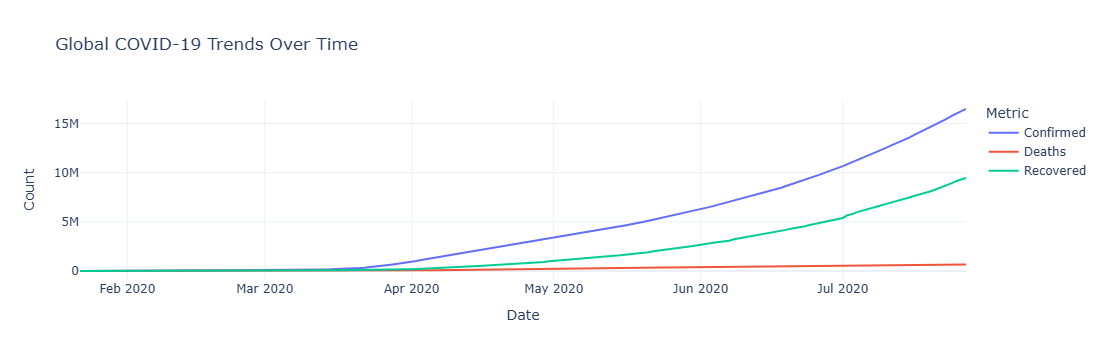

Global trends chart created


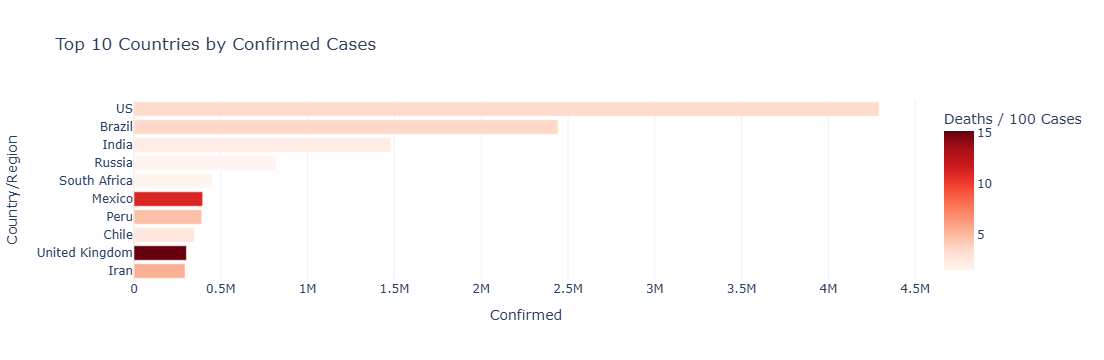

Top 10 countries chart created


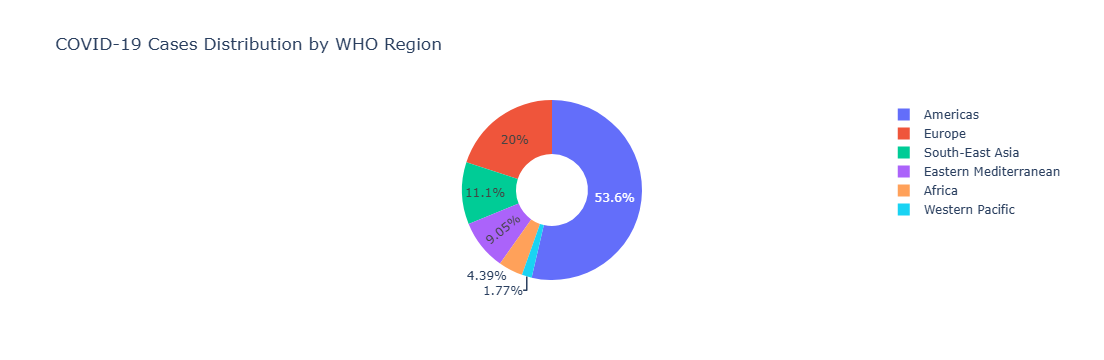

WHO Region pie chart created

TEST VISUALIZATIONS COMPLETE!


In [13]:
# Test 1: Global trend over time
fig1 = px.line(day_wise_clean, 
               x='Date', 
               y=['Confirmed', 'Deaths', 'Recovered'],
               title='Global COVID-19 Trends Over Time',
               labels={'value': 'Count', 'variable': 'Metric'},
               template='plotly_white')
fig1.update_layout(hovermode='x unified')
fig1.show()
print("Global trends chart created")

# Test 2: Top 10 countries bar chart
top10_data = country_latest_clean.nlargest(10, 'Confirmed')
fig2 = px.bar(top10_data,
              x='Confirmed',
              y='Country/Region',
              orientation='h',
              title='Top 10 Countries by Confirmed Cases',
              color='Deaths / 100 Cases',
              color_continuous_scale='Reds')
fig2.update_layout(yaxis={'categoryorder': 'total ascending'})
fig2.show()
print("Top 10 countries chart created")

# Test 3: WHO Region comparison
region_totals = country_latest_clean.groupby('WHO Region')['Confirmed'].sum().reset_index()
fig3 = px.pie(region_totals,
              values='Confirmed',
              names='WHO Region',
              title='COVID-19 Cases Distribution by WHO Region',
              hole=0.4)
fig3.show()
print("WHO Region pie chart created")

print("\nTEST VISUALIZATIONS COMPLETE!")

# Create Helper Functions

In [14]:
def get_country_data(country_name, df=full_grouped_clean):
    """Get time series data for a specific country"""
    return df[df['Country/Region'] == country_name].sort_values('Date')

def calculate_growth_rate(series):
    """Calculate growth rate for a pandas series"""
    return series.pct_change() * 100

def get_top_n_countries(n=10, metric='Confirmed', df=country_latest_clean):
    """Get top N countries by specified metric"""
    return df.nlargest(n, metric)[['Country/Region', metric]]

def plot_country_comparison(countries, metric='Confirmed'):
    """Plot comparison of multiple countries over time"""
    df_subset = full_grouped_clean[full_grouped_clean['Country/Region'].isin(countries)]
    fig = px.line(df_subset, 
                  x='Date', 
                  y=metric,
                  color='Country/Region',
                  title=f'{metric} Cases Comparison',
                  template='plotly_white')
    fig.show()
    return fig

def get_region_summary(region_name, df=country_latest_clean):
    """Get summary statistics for a WHO region"""
    region_data = df[df['WHO Region'] == region_name]
    summary = {
        'Total_Countries': len(region_data),
        'Total_Confirmed': region_data['Confirmed'].sum(),
        'Total_Deaths': region_data['Deaths'].sum(),
        'Total_Recovered': region_data['Recovered'].sum(),
        'Avg_Mortality_Rate': region_data['Deaths / 100 Cases'].mean(),
        'Avg_Recovery_Rate': region_data['Recovered / 100 Cases'].mean()
    }
    return pd.Series(summary)

print("HELPER FUNCTIONS DEFINED!")
print("\nAvailable functions:")
print("  - get_country_data(country_name)")
print("  - calculate_growth_rate(series)")
print("  - get_top_n_countries(n, metric)")
print("  - plot_country_comparison(countries, metric)")
print("  - get_region_summary(region_name)")

HELPER FUNCTIONS DEFINED!

Available functions:
  - get_country_data(country_name)
  - calculate_growth_rate(series)
  - get_top_n_countries(n, metric)
  - plot_country_comparison(countries, metric)
  - get_region_summary(region_name)


# Save Cleaned Data

In [16]:
print("\nSAVING CLEANED DATA...")

# Create output directory if it doesn't exist
import os
output_path = '../data/cleaned/'
os.makedirs(output_path, exist_ok=True)

# Save cleaned datasets
country_latest_clean.to_csv(output_path + 'country_latest_clean.csv', index=False)
day_wise_clean.to_csv(output_path + 'day_wise_clean.csv', index=False)
full_grouped_clean.to_csv(output_path + 'full_grouped_clean.csv', index=False)
worldometer_clean.to_csv(output_path + 'worldometer_clean.csv', index=False)
covid_complete_clean.to_csv(output_path + 'covid_complete_clean.csv', index=False)

print("All cleaned datasets saved!")
print(f"Location: {output_path}")


SAVING CLEANED DATA...
All cleaned datasets saved!
Location: ../data/cleaned/
